# RNN을 이용한 문서 분류 - NLTK 영화 리뷰 감성분석



- 런타임 유형 GPU로 설정

- 감성분석은 긍정과 부정 중 하나를 선택하는 이진 분류 문제이므로, 신경망의 최종 출력단 크기는 1, 활성화 함수는 시그모이드가 된다. 또한 손실 함수는 binary_crossentropy를 사용한다.

In [ ]:
from nltk.corpus import movie_reviews
import nltk
nltk.download('movie_reviews')

fileids = movie_reviews.fileids()
print(fileids)

reviews = [movie_reviews.raw(fileid) for fileid in fileids]
# print(reviews[0])

# print(movie_reviews.categories('neg/cv000_29416.txt'))
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]
# print(categories)
#file id를 이용해 label로 사용할 category 즉 positive와 negative 정보를 순서대로 가져옴

print('Reviews count:', len(reviews))
print('Length of the first review:', len(reviews[0]))
print('Labels:', set(categories))

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


['neg/cv000_29416.txt', 'neg/cv001_19502.txt', 'neg/cv002_17424.txt', 'neg/cv003_12683.txt', 'neg/cv004_12641.txt', 'neg/cv005_29357.txt', 'neg/cv006_17022.txt', 'neg/cv007_4992.txt', 'neg/cv008_29326.txt', 'neg/cv009_29417.txt', 'neg/cv010_29063.txt', 'neg/cv011_13044.txt', 'neg/cv012_29411.txt', 'neg/cv013_10494.txt', 'neg/cv014_15600.txt', 'neg/cv015_29356.txt', 'neg/cv016_4348.txt', 'neg/cv017_23487.txt', 'neg/cv018_21672.txt', 'neg/cv019_16117.txt', 'neg/cv020_9234.txt', 'neg/cv021_17313.txt', 'neg/cv022_14227.txt', 'neg/cv023_13847.txt', 'neg/cv024_7033.txt', 'neg/cv025_29825.txt', 'neg/cv026_29229.txt', 'neg/cv027_26270.txt', 'neg/cv028_26964.txt', 'neg/cv029_19943.txt', 'neg/cv030_22893.txt', 'neg/cv031_19540.txt', 'neg/cv032_23718.txt', 'neg/cv033_25680.txt', 'neg/cv034_29446.txt', 'neg/cv035_3343.txt', 'neg/cv036_18385.txt', 'neg/cv037_19798.txt', 'neg/cv038_9781.txt', 'neg/cv039_5963.txt', 'neg/cv040_8829.txt', 'neg/cv041_22364.txt', 'neg/cv042_11927.txt', 'neg/cv043_16808.t

- 케라스가 제공하는 토크나이저를 사용해 RNN모형에 적합한 형태로 입력 데이터를 변환한다.
- 케라스가 제공하는 토크나이저는 기본적인 토큰화 기능 외에, 토큰, 즉, 단어에 인덱스(고유한 숫자)를 부여해서 사전을 작성하고, 이 인덱스를 이용해 주어진 문장을 변환하는 기능을 제공한다.
- Tokenizer객체를 생성할 때 num_words를 이용해 모형에 사용할 단어 수를 결정할 수 있다.
- fit_on_text()는 이 사전을 이용해 문서들을 인덱스의 시퀀스로 변환한다.
- num_words에 지정된 값보다 큰 경우에는, 사전에 포함되지 않는 단어(out-of-vocabulary)를 빼고 시퀀스를 생성한다.
- oov_token 매개변수를 이용해 단어들을 반환할 문자열을 할당할 수 있고, 이 경우에는 사전에 없는 단어들이 생략되는 대신 공통의 값으로 변환되어 들어간다.

In [ ]:
#단어 인덱스 사용 레슨
from keras.preprocessing.text import Tokenizer

# 가상의 텍스트 데이터셋 생성
documents = [
    "I love natural language processing.",
    "Tokenizer is a useful tool in NLP.",
    "NLP helps us understand human languages.",
    "Machine learning is a core part of NLP.",
]

# Tokenizer 객체 생성 및 텍스트 데이터를 토큰화
# num_words: 사용할 최대 단어 개수 설정
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(documents)

# 단어들을 정수 인덱스로 변환
sequences = tokenizer.texts_to_sequences(documents)

# 각 단어의 인덱스 사전 출력
word_index = tokenizer.word_index
print("단어 인덱스 사전:\n", word_index)

# 텍스트 데이터를 정수 시퀀스로 변환한 결과 출력
print("정수 시퀀스:\n", sequences)

# 특정 단어의 인덱스 번호 확인하기
word_index = tokenizer.word_index["language"]
print("해당 단어의 Index번호 : ", word_index)

단어 인덱스 사전:
 {'nlp': 1, 'is': 2, 'a': 3, 'i': 4, 'love': 5, 'natural': 6, 'language': 7, 'processing': 8, 'tokenizer': 9, 'useful': 10, 'tool': 11, 'in': 12, 'helps': 13, 'us': 14, 'understand': 15, 'human': 16, 'languages': 17, 'machine': 18, 'learning': 19, 'core': 20, 'part': 21, 'of': 22}
정수 시퀀스:
 [[4, 5, 6, 7, 8], [9, 2, 3, 10, 11, 12, 1], [1, 13, 14, 15, 16, 17], [18, 19, 2, 3, 20, 21, 22, 1]]
해당 단어의 Index번호 :  7


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# np.random.seed(7)
# tf.random.set_seed(7)

# 빈도가 높은 10000개의 단어를 선택하도록 객체 생성
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')

#단어 인덱스 구축
tokenizer.fit_on_texts(reviews)

#만들어진 단어 인덱스를 이용해 문서들을 변환
X = tokenizer.texts_to_sequences(reviews)

print('Lengths of first 10 documents:', [len(doc) for doc in X[:10]])
print(len(X[0]))
print(X[0])
print(X[:10])
print(len(X))

Lengths of first 10 documents: [710, 240, 486, 479, 733, 671, 550, 584, 702, 776]
710
[98, 77, 949, 4622, 131, 6, 3, 2016, 789, 3764, 4, 103, 1314, 37, 73, 56, 25, 1341, 24, 5, 2, 519, 1325, 17, 14, 678, 1571, 6, 84, 55, 8, 34, 90, 4, 33, 4477, 604, 2, 638, 242, 2, 27, 4, 8854, 190, 41, 2186, 3, 302, 6462, 27, 13, 2, 949, 1458, 9, 2402, 20, 3, 80, 691, 362, 17, 1768, 10, 8, 3, 80, 106, 3980, 46, 7, 49, 143, 15, 466, 25, 57, 3668, 24, 6, 1175, 195, 19, 1342, 8855, 96, 46, 527, 6, 831, 2, 7098, 903, 12, 170, 363, 4, 118, 342, 4204, 8856, 17, 53, 21, 62, 4, 106, 753, 5, 243, 36, 2695, 5, 96, 4, 113, 1879, 51, 249, 1, 15, 24, 6180, 37, 250, 6, 32, 625, 15, 272, 3765, 1224, 17, 2795, 10, 2284, 40, 49, 21, 2, 470, 12, 2, 27, 78, 65, 349, 354, 7, 9, 38, 322, 89, 7840, 10, 437, 88, 1315, 17, 103, 1, 56, 15, 1446, 146, 8, 46, 35, 11, 25, 162, 1123, 32, 60, 362, 604, 160, 20, 53, 21, 1077, 53, 21, 82, 505, 136, 29, 2, 329, 53, 21, 486, 28, 178, 39, 2, 329, 53, 21, 770, 1, 53, 21, 1, 53, 21, 3, 1

In [ ]:
print("Index of 'the':", tokenizer.word_index["the"])
print("Index of 'review':", tokenizer.word_index["review"])
print("Index of out-of-vocabulary words:", tokenizer.word_index["UNK"])

Index of 'the': 2
Index of 'review': 466
Index of out-of-vocabulary words: 1


- 각 리뷰의 길이가 다르므로 위에서 확인한 바와 같이 문서로부터 변환된 인덱스 시퀀스의 길이도 가변적일 수밖에 없다. 그러나 신경망 모형의 입력은 길이가 일정해야 하므로, 다음과 같이 pad_sequences()를 이용해 모든 입력 시퀀스의 길이를 매개변수 maxlen의 인수만큼 동일하게 변환한다.
- 이때 시퀀스 크기가 maxlen보다 크면 남는 부분을 잘라야 하는데, truncating매개변수는 잘라낼 부분의 위치를 지정한다. 'pre'이면 시퀀스의 앞을 잘라내고, 'post'이면 뒤를 잘라낸다. 크기가 maxlen보다 작으면 남는 부분을 0을 채운다.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 500 #문서의 단어 수를 제한

# 문서의 단어 수가 500보다 작으면 0을 채우고, 크면 잘라냄
# 잘라낼 때, 앞을 자를 지, 뒤를 자를 지 선택할 수 있음. 앞을 자르고 뒷부분을 쓰고자 하면 'pre' 선택
X = pad_sequences(X, maxlen=maxlen, truncating='pre')
X

array([[ 911,  115,   53, ..., 3865, 1023,  303],
       [   0,    0,    0, ...,    5,    3,   27],
       [   0,    0,    0, ...,   30,   36, 4625],
       ...,
       [  37,  109, 1399, ..., 5390,    5,  862],
       [ 471,   21,  185, ...,    5,    2,  199],
       [1349,  146,  244, ...,   10,  171,   23]], dtype=int32)

In [ ]:
import numpy as np

# label을 0, 1의 값으로 변환
label_dict = {'pos':1, 'neg':0}
y = np.array([label_dict[c] for c in categories])
print(y)
print(set(y))

[0 0 0 ... 1 1 1]
{0, 1}


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1]


# RNN이 아닌 일반적인 신경망 모형을 이용한 분류

- 단어 임베딩에 대해 이해하고 RNN의 효과를 비교하기 위해 먼저 로지스틱 회귀모형을 시퀀스 정보 없이 예측을 수행해본다.

- 하기 예제는 임베딩(Embedding)레이어, Flatten()레이어, Dense() 레이어로 이루어진 Sequential 모형을 만드는 예이다.
- 임베딩 레이어: RNN을 위해 만든 입력을 받아서 원핫 인코딩과 워드 임베딩을 수행하는 레이어
- 워드 임베딩: 원핫 인코딩된 단어들을 일정한 크기의 밀집 벡터로 변환한다. 아래 예제에서는 벡터의 크기를 32로 지정하고 있다. 즉 크기가 10,000이었던 단어 벡터는 32의 크기로 압축되는데, 이를 위해서는 10,000*32 만큼의 파라미터 혹은 가중치 변수가 요구된다. 모든 단어에 동일한 가중치를 적용해 워드 임베딩을 수행하므로 문서의 크기인 500은 파라미터의 수에 반영되지 않는다. 모형을 만들고 summary()메서드를 이용하면 아래와 같이 층별로 출력의 모양과 파라미터의 수를 확인할 수 있는데, 처음에는 항상 확인하자

- 아래 예에서 볼 수 있듯이 워드 임베딩을 한 결과는 (단어의 수, 단어를 표현하는 밀집 벡터의 크기)의 2차원 행렬이 된다.
- 아래 Output Shape의 가장 앞에 있는 None은 학습에 사용되는 입력의 수를 나타낸다. 한 번의 학습에 사용되는 입력의 수는 가변적이므로 모형을 정의하는 단계에서는 설정하지 않는다. 즉, None뒤의 값들로 하나의 입력값, 즉 문서에 대한 내부적인 모양을 확인하면 된다.

- Flatten()레이어는 2차원 행렬의 형태로 된 값을 펼쳐서 1차원 벡터로 변환한다. 형태만 변경하므로 별도의 파라미터는 사용하지 않는다. Flatten()으로 500개의 단어에 대한 각 32개의 값들을 펼쳐서 총 500*32개의 독립적인 입력변수로 변환한 후, 이를 이용해 이진 로지스틱 회귀분석을 실시한다. (비교를 위해)

- Dense()레이어는 우리가 일반적인 신경망의 은닉층으로 알고 있는, 모든 노드들이 연결되는 밀집 층을 생성한다. 여기서는 출력의 크기를 1로 하고 활성화 함수로 sigmoid를 지정하는데, 이는 감성분석을 위해 이진 분류를 해야 하기 때문이다. 이렇게 나타내는 0과 1사이의 값 하나를 출력한다.

In [ ]:
# 케라스 모형 생성 및 학습
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential([ #순차적 모형
    Embedding(max_words, 32, input_length=maxlen), #word embedding layer 생성
    # max_words는 one-hot encoding을 할 때의 vector 크기가 됨 - 사용된 단어의 수만큼
    # 각 단어는 32 크기의 dense vector로 embedding 됨
    # input_length는 한 document의 단어 수로 표현
    # 이 과정을 거치면 각 document는 (maxlen, 32)의 2차원 행렬이 됨 - 즉 word의 sequence가 됨

    Flatten(), # 2차원 행렬을 1차원으로 펼침
    Dense(1, activation='sigmoid')#binary logistic regression을 수행
])

model.summary() #모델의 요약정보 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 1)                 16001     
                                                                 
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________


- 학습을 수행한다
- 학습을 하려면 손실함수와 옵티마이저를 설정해야 한다.
- 이진 분류이므로 손실 함수는 'binary_crossentrpy'
- 옵티마이저는 'rmsprop'를 사용한다.

- fit()메서드는 학습 데이터셋을 이용해 학습을 수행한다. 학습을 위한 입력과 라벨을 반드시 지정해야 하며, epochs는 학습의 반복횟수, verbose는 학습 진행 중 학습현황의 출력 여부, validation_split은 학습을 하면서 사용할 검증 데이터셋(validation_set)의 비율을 지정한다.

In [ ]:
# 모형의 optimizer와 loss function 등을 지정
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# 학습을 수행
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 2s 22ms/step - loss: 0.6937 - acc: 0.4930 - val_loss: 0.6878 - val_acc: 0.5344
Epoch 2/10
40/40 [==============================] - 0s 11ms/step - loss: 0.6182 - acc: 0.8914 - val_loss: 0.6813 - val_acc: 0.5750
Epoch 3/10
40/40 [==============================] - 0s 10ms/step - loss: 0.5186 - acc: 0.9680 - val_loss: 0.6702 - val_acc: 0.5813
Epoch 4/10
40/40 [==============================] - 0s 9ms/step - loss: 0.3905 - acc: 0.9898 - val_loss: 0.6533 - val_acc: 0.5969
Epoch 5/10
40/40 [==============================] - 0s 9ms/step - loss: 0.2623 - acc: 0.9953 - val_loss: 0.6352 - val_acc: 0.6219
Epoch 6/10
40/40 [==============================] - 0s 9ms/step - loss: 0.1591 - acc: 0.9992 - val_loss: 0.6214 - val_acc: 0.6438
Epoch 7/10
40/40 [==============================] - 0s 10ms/step - loss: 0.0906 - acc: 1.0000 - val_loss: 0.6143 - val_acc: 0.6469
Epoch 8/10
40/40 [==============================] - 0s 10ms/step - loss: 0.0494 - acc:

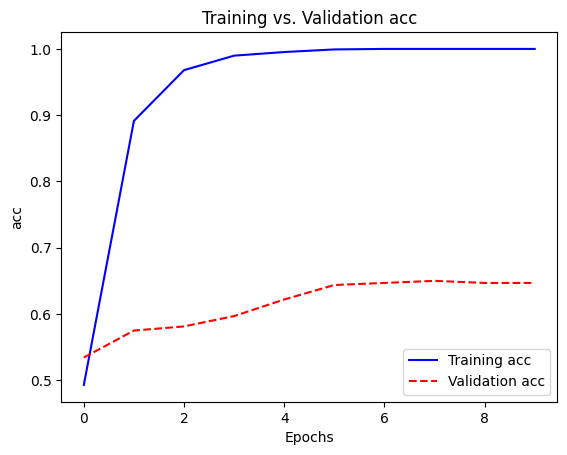

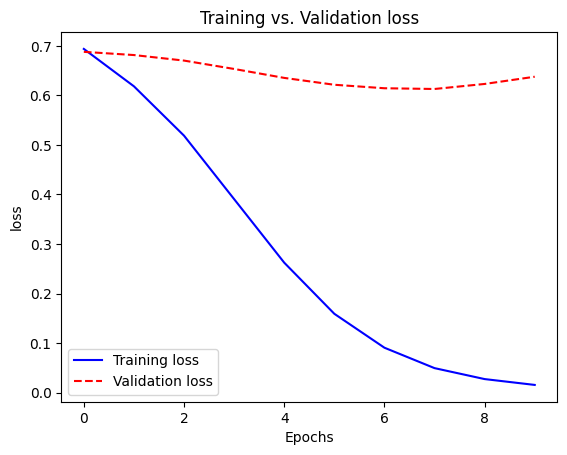

In [ ]:
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label='Training '+metric)
    plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_results(history, 'acc')
plot_results(history, 'loss')

# 문서의 순서정보를 활용하는 RNN 기반 문서분류

- 앞의 모형과 가장 큰 차이점은 Flatten()대신에 SimpleRNN() 레이어를 사용함으로써 가장 기본적인 RNN층을 추가하는 것이다.
- 인수 32는 은닉 노드의 크기이다.
- SImpleRNN() 레이어 뒤에 Dense()레이어를 추가했는데, 최종 노드에 대해 은닉층 하나를 추가해 모형의 성능을 높인 것이다.
- 속도를 위해 활성화 함수는 relu로 지정했다.
- 옵티마이저는 이전 모형의 rmsprop대신에 Adam을 사용했다.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 323,169
Trainable params: 323,169
Non-trainable params: 0
_________________________________________________________________


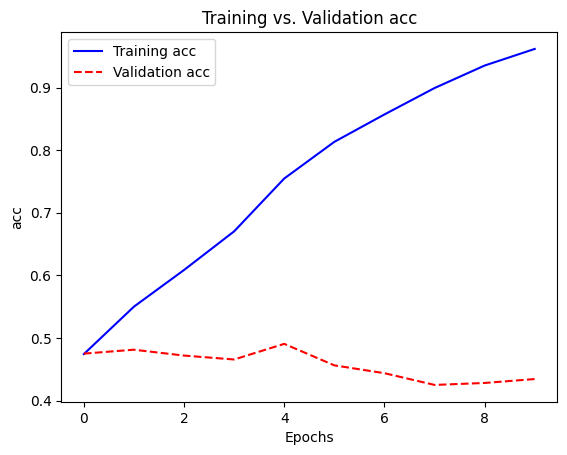

13/13 [==============================] - 1s 41ms/step - loss: 0.7391 - acc: 0.4825
#Test accuracy:0.482


In [ ]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(max_words, 32),
    SimpleRNN(32), # 펼쳐서 flat하게 만드는 대신 RNN 모형을 사용, maxlen만큼의 시계열 데이터
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=0,
                    validation_split=0.2)

plot_results(history, 'acc')
#테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

In [ ]:
y_pred = np.round(model.predict(X_test[:10]))
for pred, y_t in zip(y_pred, y_test[:10]):
    print(f'predicted value: {pred[0]}, true value: {y_t}, so the prediction is {pred[0] == y_t}')

1/1 [==============================] - 0s 42ms/step
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 0.0, true value: 1, so the prediction is False
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 0.0, true value: 1, so the prediction is False
predicted value: 1.0, true value: 0, so the prediction is False
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 0, so the prediction is False
predicted value: 0.0, true value: 0, so the prediction is True


- 위 결과를 보면 학습이 거의 이뤄지지 않는 것을 볼 수 있다. 학습 데이터셋에 대한 정확도는 1.0근처까지 꾸준하게 올라갔으나, 검증 데이터셋에 대한 정확도는 0.5근처에서 벗어나지 못하고 있다. 즉 과대적합만 이루어지고 있을 뿐, 실제 학습은 거의 되지 않고 있다. 테스트 데이타의 정확도가 말해준다.
- 왜? 경사소실의 문제, 하나의 문서는 500개의 단어로 이루어지는데 이는 500개의 층이 겹겹이 쌓여 있는 것으로 볼 수 있다. 즉 RNN의 목적은 앞에서부터 순서에 따라 다음 단어에 미치는 영향을 축적하는 것인데, 이것이 경사소실 문제로 인해 학습이 잘 되지 못하고 있다.
- RNN의 가장 큰 문제

#LSTM

- LSTM을 적용하고 싶다면 SImpleRNN 대신에 LSTM을 임포트해서 쓰면된다.
- 양방향 LSTM을 원한다면 Bidirectional로 LSTM레이어를 감싸주면 된다.

- 성능을 높여보기 위해 워드 임베딩 벡터의 크기를 64로 늘리고, 양방향 LSTM을 구현한다.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714,369
Trainable params: 714,369
Non-trainable params: 0
_________________________________________________________________


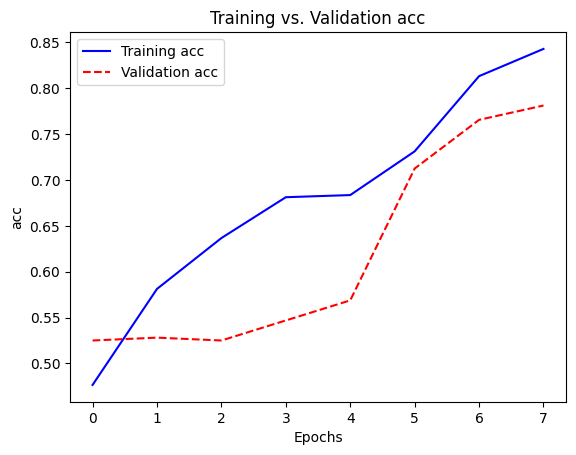

13/13 [==============================] - 3s 121ms/step - loss: 0.5220 - acc: 0.7575
#Test accuracy:0.757


In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.optimizers.legacy import Adam

model = Sequential([
    Embedding(max_words, 64),
    Bidirectional(LSTM(64)), # simple RNN 대신 bidirectional LSTM을 사용
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=8, verbose=0, validation_split=0.2)

plot_results(history, 'acc')

#테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

In [ ]:
y_pred = np.round(model.predict(X_test[:10]))
for pred, y_t in zip(y_pred, y_test[:10]):
    print(f'predicted value: {pred[0]}, true value: {y_t}, so the prediction is {pred[0] == y_t}')

1/1 [==============================] - 1s 870ms/step
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 0, so the prediction is False
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 0.0, true value: 0, so the prediction is True


- 결과가 맘에 들지 않는다.
- 이유는 딥러닝의 경우 로지스틱 회귀분석이나 나이브 베이즈와 같은 방법에 비해 더욱 많은 데이터를 요구한다. 워드 임베딩 단계에서 각 단어들은 말뭉치 안에서 의미를 학습해서 밀집 벡터로 변환되는데, 말뭉치가 충분하지 않으면 제대로 학습이 이뤄지지 않는다.
- 이를 개선하기 위해서 워드 임베딩 벡터에 대해 학습된 가중치를 Word2Vec과 같은 기존의 학습된 모형으로부터 가져올 수 있다.
- 이외에 단어의 수가 500개 이상인 문서들은 내용이 잘리는 것, 검증 데이터셋으로 인해 머신러닝에 비해 더 적은 수의 학습 데이터로 하습한다는 것, 과대적합 등이 원인